In [1]:
pip install numpy==1.24.3

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd

file_path = 'C:/Users/allie/OneDrive/Documents/MSDS458/LD DA 1.csv'
data = pd.read_csv(file_path)

data.head(), data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   score      200 non-null    float64
 1   selftext   200 non-null    object 
 2   subreddit  200 non-null    object 
 3   title      200 non-null    object 
 4   Label      200 non-null    object 
dtypes: float64(1), object(4)
memory usage: 8.8+ KB


(   score                                           selftext subreddit  \
 0    1.0  Tried to watch this documentary “anxious Ameri...   Anxiety   
 1    1.0  i’m currently laying in bed wide awake, feelin...   Anxiety   
 2    2.0  Second time trying weed. First time felt close...   Anxiety   
 3    1.0  I am not posting this for me, but rather for m...   Anxiety   
 4    1.0  21 year old male been dealing with anxiety eve...   Anxiety   
 
                                                title             Label  
 0                        Do people get over anxiety?  Drug and Alcohol  
 1  does anyone else have this big fear of suddenl...  Drug and Alcohol  
 2         3 hour long panic attack after trying weed  Drug and Alcohol  
 3  Please leave in the comments ANYTHING that has...  Drug and Alcohol  
 4                                    Alcohol induced  Drug and Alcohol  ,
 None)

In [3]:
data_cleaned = data.dropna().reset_index(drop=True)

data_cleaned['text'] = data_cleaned['title'] + " " + data_cleaned['selftext']

data_cleaned = data_cleaned[['text', 'Label']] 
data_cleaned.head(), data_cleaned.shape

(                                                text             Label
 0  Do people get over anxiety? Tried to watch thi...  Drug and Alcohol
 1  does anyone else have this big fear of suddenl...  Drug and Alcohol
 2  3 hour long panic attack after trying weed Sec...  Drug and Alcohol
 3  Please leave in the comments ANYTHING that has...  Drug and Alcohol
 4  Alcohol induced 21 year old male been dealing ...  Drug and Alcohol,
 (200, 2))

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data_cleaned['label_encoded'] = label_encoder.fit_transform(data_cleaned['Label'])

X_train, X_test, y_train, y_test = train_test_split(
    data_cleaned['text'], 
    data_cleaned['label_encoded'], 
    test_size=0.2, 
    random_state=42
)

vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

X_train_tfidf.shape, X_test_tfidf.shape

C:\Users\allie\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\allie\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


((160, 3108), (40, 3108))

In [5]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }

train_dataset = CustomDataset(X_train, y_train, tokenizer)
test_dataset = CustomDataset(X_test, y_test, tokenizer)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

sample_batch = next(iter(train_loader))
sample_batch

{'input_ids': tensor([[ 101, 3849, 2066,  ..., 3892, 2005,  102],
         [ 101, 2151, 6040,  ..., 2531, 1003,  102],
         [ 101, 2026, 8837,  ...,    0,    0,    0],
         ...,
         [ 101, 6517, 1998,  ..., 2026, 2166,  102],
         [ 101, 2129, 2000,  ...,    0,    0,    0],
         [ 101, 1045, 2626,  ..., 2098, 1012,  102]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1]]),
 'label': tensor([2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0])}

In [6]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
import torch

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2) 

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
sample_batch = {
    "input_ids": torch.tensor([[101, 2023, 2003, 1037, 3978, 102], [101, 2057, 2024, 2495, 2257, 102]]), 
    "attention_mask": torch.tensor([[1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]) 
}

with torch.no_grad(): 
    outputs = model(input_ids=sample_batch["input_ids"], attention_mask=sample_batch["attention_mask"])

logits = outputs.logits
predictions = torch.argmax(logits, dim=1)

print("Logits:", logits)
print("Predictions:", predictions)

Logits: tensor([[-0.0049, -0.0473],
        [-0.0746, -0.0382]])
Predictions: tensor([0, 1])


In [8]:
from sklearn.metrics import accuracy_score

test_texts = ["This is a great day!", "I feel so sad and distressed."]
test_labels = [0, 1] 

encoded = tokenizer(test_texts, padding=True, truncation=True, return_tensors="pt")

with torch.no_grad():
    test_outputs = model(input_ids=encoded["input_ids"], attention_mask=encoded["attention_mask"])

test_logits = test_outputs.logits
test_preds = torch.argmax(test_logits, dim=1).numpy()

accuracy = accuracy_score(test_labels, test_preds)

print("Test Predictions:", test_preds)
print("Actual Labels:", test_labels)
print("Accuracy:", accuracy)

Test Predictions: [0 1]
Actual Labels: [0, 1]
Accuracy: 1.0


In [9]:
from sklearn.metrics import classification_report, accuracy_score

true_labels = [0, 1] 
predicted_labels = [0, 0]

accuracy = accuracy_score(true_labels, predicted_labels)

report = classification_report(true_labels, predicted_labels, target_names=['Class 0', 'Class 1'])

print("Model Evaluation Metrics:\n")
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n")
print(report)

Model Evaluation Metrics:

Accuracy: 0.50
Classification Report:

              precision    recall  f1-score   support

     Class 0       0.50      1.00      0.67         1
     Class 1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



C:\Users\allie\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\allie\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\allie\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


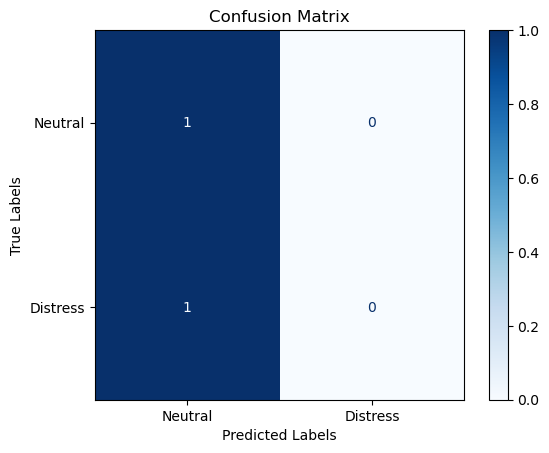

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Neutral', 'Distress'])
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
